In [3]:
import os
import numpy as np
import pandas as pd
import json 
import csv
from datetime import date, timedelta, datetime
from dateutil import tz
import time
import shutil
import gzip
from collections import defaultdict

In [4]:
# DataCollection csv with annotated timestamp data
path_gt = r'C:\Users\yjian\OneDrive - binghamton.edu\PHD LIFE\Research\Cough Detection\COURSE PROJECT\Cough_data collection.csv'

with open(path_gt) as GT:
    reader = csv.reader(GT)
    header = next(reader)
    GT = [r for r in reader]


# Read raw accelerometer data
path_a = r'C:\Users\yjian\OneDrive - binghamton.edu\PHD LIFE\Research\Cough Detection\COURSE PROJECT\Smartwatch_AccelerometerDatum.csv'

with open(path_a) as A:
    reader = csv.reader(A)
    header = next(reader)
    A = [r for r in reader]

In [5]:
####################################
### --- Define time function --- ###
####################################


# Format timestamp and convert from GMT to EST for comparison purposes
def formatTimestamp(Timestamp):
    
    timestamp = Timestamp[:19]
    timestamp = datetime.strptime(timestamp,  "%Y-%m-%dT%H:%M:%S")
    
    from_zone = tz.gettz('UTC')
    to_zone = tz.gettz('America/New_York')
    
    timestamp = timestamp.replace(tzinfo = from_zone)
    
    timestamp = timestamp.astimezone(to_zone).strftime('%Y-%m-%d %H:%M:%S')
    
    return datetime.strptime(timestamp,  "%Y-%m-%d %H:%M:%S")


# Define function: convert time to seconds
def TimetoSecond(Time):
    
    TH = int(Time.strftime("%H%M%S")[0])*10 + int(Time.strftime("%H%M%S")[1]*1)
    TM = int(Time.strftime("%H%M%S")[2])*10 + int(Time.strftime("%H%M%S")[3]*1)
    TS = int(Time.strftime("%H%M%S")[4])*10 + int(Time.strftime("%H%M%S")[5]*1)
    
    TtoS = TH*3600 + TM*60 + TS
    
    return TtoS


# Define function: compare two times and return difference (Assume Time2 > Time1)
def Timecompare(Time1,Time2):
    
    Time1 = TimetoSecond(Time1)
    Time2 = TimetoSecond(Time2)
    
    Diff = Time2 - Time1
    
    return Diff


# Define function: convert time in seconds to real time
def SecondtoTime(Seconds):
    
    h=int(Seconds/3600)
    sUp_h=Seconds-3600*h
    m=int(sUp_h/60)
    sUp_m=sUp_h-60*m
    s=sUp_m
    
    return ":".join(map(str,(h,m,s)))


In [6]:
#Convert time from GMT to EST in original csv data

for i in range(len(A)):
    A[i][5] = formatTimestamp(A[i][5])

In [7]:
############################
### --- Data storage --- ###
############################

# Define function: Cough data input
def Coughinput(Deviceid,Participantid,Hand,X,Y,Z,Timestamp,Activity,Status,Context):
    
    DeviceidA.append(Deviceid)
    ParticipantidA.append(Participantid)
    HandA.append(Hand)
    XA.append(X)
    YA.append(Y)
    ZA.append(Z)
    TimestampA.append(Timestamp)
    ActivityA.append(Activity)
    StatusA.append(Status)
    ContextA.append(Context)

    
#Define function: Non-cough data input
def Noncoughinput(Deviceid,Participantid,Hand,X,Y,Z,Timestamp,Status,Context):
    
    DeviceidA.append(Deviceid)
    ParticipantidA.append(Participantid)
    HandA.append(Hand)
    XA.append(X)
    YA.append(Y)
    ZA.append(Z)
    TimestampA.append(Timestamp)
    ActivityA.append("Non-cough")
    StatusA.append(Status)
    ContextA.append(Context)

In [8]:
#Creat lists for variables
DeviceidA = []
ParticipantidA = []
HandA = []
XA = []
YA = []
ZA = []
TimestampA = []
ActivityA = []
StatusA = []
ContextA = []

In [9]:
#########################
### --- Main code --- ###
#########################


#Define starting and ending times for both groups 
data_collection_start01 = datetime.strptime("10/25/18 16:04:29",  "%m/%d/%y %H:%M:%S").time()
data_collection_end01 = datetime.strptime("10/25/18 17:23:11",  "%m/%d/%y %H:%M:%S").time()

data_collection_start23 = datetime.strptime("10/25/18 16:12:21",  "%m/%d/%y %H:%M:%S").time()
data_collection_end23 = datetime.strptime("10/25/18 17:32:32",  "%m/%d/%y %H:%M:%S").time()


PID = 0 #define participant id
pin = 0 #pin of silent period
i = 0 #number of groundtruth

# Label the data
for line in A:
    current_time = line[5].time() #define current time
    
    if line[0] == '0' or line[0] == '1':
        if i == 168: i = 0
        if data_collection_start01 <= current_time <= data_collection_end01 and i <= 81:
            
            ####define cough time interval
            cough_time = datetime.strptime(GT[i+pin-1][3], "%H:%M:%S").time()
            cough_time_s = datetime.strptime(SecondtoTime((TimetoSecond(cough_time)-1)), "%H:%M:%S").time() #Starting time: 1s before current timestamp
            cough_time_e = datetime.strptime(SecondtoTime((TimetoSecond(cough_time)+1)), "%H:%M:%S").time() #Ending time: 1s later than current timestamp
           
            ####define event interval
            #lower bound
            lower_bound = datetime.strptime(SecondtoTime((TimetoSecond(datetime.strptime(GT[i][3], "%H:%M:%S").time())-20)), "%H:%M:%S").time()
            
            #upper bound
            upper_bound = datetime.strptime(SecondtoTime((TimetoSecond(datetime.strptime(GT[i+2][3], "%H:%M:%S").time())+20)),"%H:%M:%S").time()
    
            if lower_bound <= current_time < upper_bound:
                if pin == 0:
                    Noncoughinput(line[0],GT[i][0],GT[i][4],line[1],line[2],line[3],line[5],GT[i][6],GT[i][7])
                    pin = pin+1
                    
                elif 1 <= pin <= 3 and current_time < cough_time_s:
                    Noncoughinput(line[0],GT[i+pin-1][0],GT[i+pin-1][4],line[1],line[2],line[3],line[5],GT[i+pin-1][6],GT[i+pin-1][7])
                
                elif 1 <= pin <= 3 and cough_time_s <= current_time < cough_time_e:
                    Coughinput(line[0],GT[i+pin-1][0],GT[i+pin-1][4],line[1],line[2],line[3],line[5],GT[i+pin-1][5],GT[i+pin-1][6],GT[i+pin-1][7])
                
                elif 1 <= pin < 3 and current_time >= cough_time_e:
                    pin = pin+1
                    Noncoughinput(line[0],GT[i+pin-1][0],GT[i+pin-1][4],line[1],line[2],line[3],line[5],GT[i+pin-1][6],GT[i+pin-1][7])
                
                elif pin == 3 and current_time >= cough_time_e:
                    Noncoughinput(line[0],GT[i+pin-1][0],GT[i+pin-1][4],line[1],line[2],line[3],line[5],GT[i+pin-1][6],GT[i+pin-1])
                    pin = pin+1
                elif pin == 4:
                    Noncoughinput(line[0],GT[i+pin-2][0],GT[i+pin-2][4],line[1],line[2],line[3],line[5],GT[i+pin-2][6],GT[i+pin-2][7])
            
            elif current_time >= upper_bound:
                pin = 0
                i = i+3
                print(i)
            
    elif line[0] == '2' or line[0] == '3':
        if i <84: i = 84
        
        if data_collection_start23 <= current_time <= data_collection_end23 and 84 <= i <= 165:
            if i+pin-1 <= len(GT)-1:
                #define cough time interval
                cough_time = datetime.strptime(GT[i+pin-1][3], "%H:%M:%S").time()
                cough_time_s = datetime.strptime(SecondtoTime((TimetoSecond(cough_time)-1)), "%H:%M:%S").time() #Starting time: 1s before current timestamp
                cough_time_e = datetime.strptime(SecondtoTime((TimetoSecond(cough_time)+1)), "%H:%M:%S").time() #Ending time: 1s later than current timestamp
           
            ####define event interval
            #lower bound
            lower_bound = datetime.strptime(SecondtoTime((TimetoSecond(datetime.strptime(GT[i][3], "%H:%M:%S").time())-20)), "%H:%M:%S").time()
            
            #upper bound
            upper_bound = datetime.strptime(SecondtoTime((TimetoSecond(datetime.strptime(GT[i+2][3], "%H:%M:%S").time())+20)),"%H:%M:%S").time()
            
            if lower_bound <= current_time < upper_bound:
                if pin == 0:
                    Noncoughinput(line[0],GT[i][0],GT[i][4],line[1],line[2],line[3],line[5],GT[i][6],GT[i][7])
                    pin = pin+1
                    
                elif 1 <= pin <= 3 and current_time < cough_time_s:
                    Noncoughinput(line[0],GT[i+pin-1][0],GT[i+pin-1][4],line[1],line[2],line[3],line[5],GT[i+pin-1][6],GT[i+pin-1][7])
                
                elif 1 <= pin <= 3 and cough_time_s <= current_time < cough_time_e:
                    Coughinput(line[0],GT[i+pin-1][0],GT[i+pin-1][4],line[1],line[2],line[3],line[5],GT[i+pin-1][5],GT[i+pin-1][6],GT[i+pin-1][7])
                
                elif 1 <= pin < 3 and current_time >= cough_time_e:
                    pin = pin+1
                    Noncoughinput(line[0],GT[i+pin-1][0],GT[i+pin-1][4],line[1],line[2],line[3],line[5],GT[i+pin-1][6],GT[i+pin-1][7])
                
                elif pin == 3 and current_time >= cough_time_e:
                    Noncoughinput(line[0],GT[i+pin-1][0],GT[i+pin-1][4],line[1],line[2],line[3],line[5],GT[i+pin-1][6],GT[i+pin-1])
                    pin = pin+1
                elif pin == 4:
                    Noncoughinput(line[0],GT[i+pin-2][0],GT[i+pin-2][4],line[1],line[2],line[3],line[5],GT[i+pin-2][6],GT[i+pin-2][7])
            
            elif current_time >= upper_bound:
                pin = 0
                i = i+3
                print(i)
    

3
6
9
12
15
18
21
24
27
30
33
36
39
42
45
48
51
54
57
60
63
66
69
72
87
90
93
96
99
102
105
108
111
114
117
120
123
126
129
132
135
138
141
144
147
150
153
156
159
162
165
168
3
6
9
12
15
18
21
24
27
30
33
36
39
42
45
48
51
54
57
60
63
66
69
72
87
90
93
96
99
102
105
108
111
114
117
120
123
126
129
132
135
138
141
144
147
150
153
156
159
162
165
168


In [39]:
#Export Labeled data into csv file

with open('New Labeled Data v2.csv','w',newline = '') as csvfile:
    spamwriter = csv.writer(csvfile,dialect='excel')
    spamwriter.writerow(['Deviceid','Participantid','Hand','X','Y','Z','Timestamp','Activity','Status','Context'])
    for k in range(len(DeviceidA)):
        spamwriter.writerow([DeviceidA[k],ParticipantidA[k],HandA[k],XA[k],YA[k],ZA[k],TimestampA[k],ActivityA[k],StatusA[k],ContextA[k]])
   

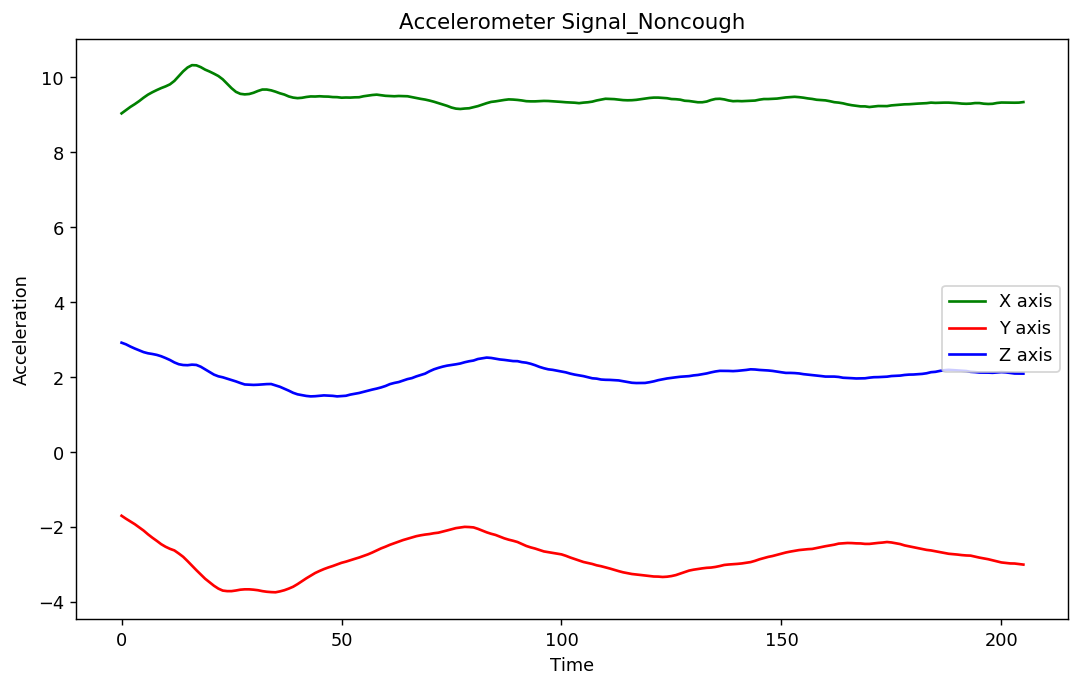

In [21]:
##########Picture of non-cough

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from pylab import *
from matplotlib.ticker import MultipleLocator, FormatStrFormatter

X_non = [float(XA[i]) for i in range(207,413)]
Y_non = [float(YA[i]) for i in range(207,413)]
Z_non = [float(ZA[i]) for i in range(207,413)]


x = np.arange(0, 206, 1)



#sub_axix = filter(lambda x:x%200 == 0, x_axix)

fig = plt.figure(dpi=128,figsize=(10,6))
#plt.axis([0, 200, -100, 1000])
plt.title('Accelerometer Signal_Noncough')
plt.plot(x, X_non, color='green', label='X axis')
plt.plot(x, Y_non, color='red', label='Y axis')
plt.plot(x, Z_non, color='blue', label='Z axis')
#fig.yaxis.set_ticks(y)
plt.legend() 
 
plt.xlabel('Time')
plt.ylabel('Acceleration')
plt.show()

In [ ]:
print(X_non.shape,Y_non.shape,Z_non.shape)

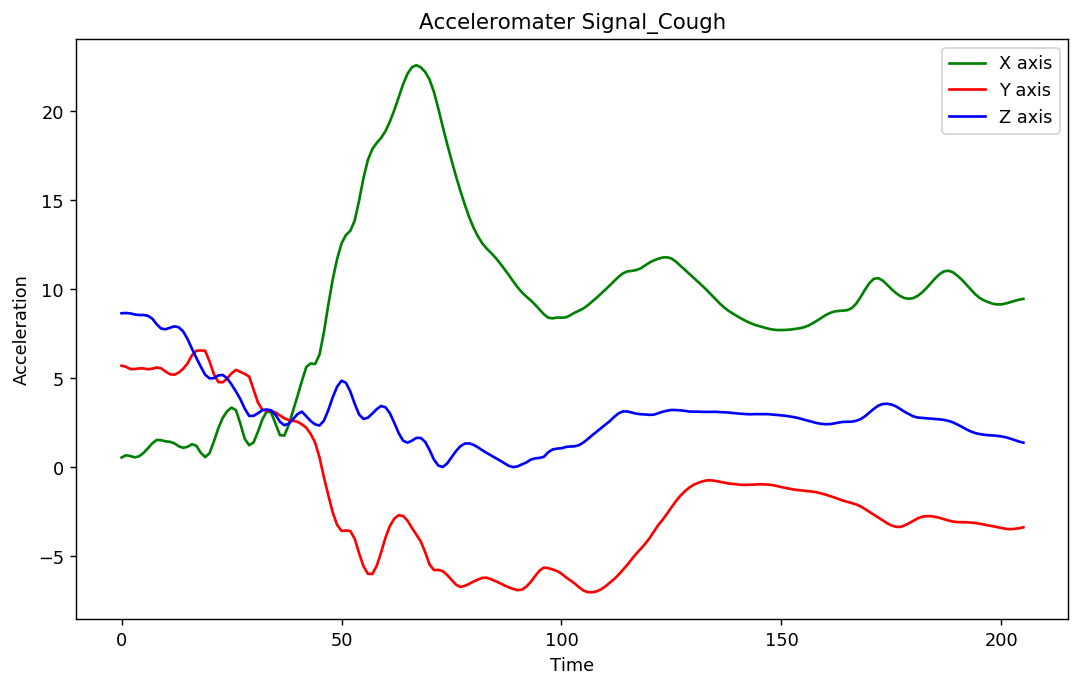

In [20]:
##########Picture of cough

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from pylab import *
from matplotlib.ticker import MultipleLocator, FormatStrFormatter

X_cough = [float(XA[i]) for i in range(4120,4326)]
Y_cough = [float(YA[i]) for i in range(4120,4326)]
Z_cough = [float(ZA[i]) for i in range(4120,4326)]


x = np.arange(0, 206, 1)



#sub_axix = filter(lambda x:x%200 == 0, x_axix)

fig = plt.figure(dpi=128,figsize=(10,6))
#plt.axis([0, 200, -100, 1000])
plt.title('Accelerometer Signal_Cough')
plt.plot(x, X_cough, color='green', label='X axis')
plt.plot(x, Y_cough, color='red', label='Y axis')
plt.plot(x, Z_cough, color='blue', label='Z axis')
#fig.yaxis.set_ticks(y)
plt.legend() 
 
plt.xlabel('Time')
plt.ylabel('Acceleration')
plt.show()